<a href="https://colab.research.google.com/github/ErialdoDFreitas/neural-networks-implementations/blob/main/MULTILAYER_PERCEPTRON/Atividade_MLP_2D_Banana_Ripley_%26_Two_Moon_AP_Erialdo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina**: Aprendizagem Profunda - PPGCC IFCE
**Professor**: Saulo Freitas \
**Aluno**: Francisco Erialdo \

#### **Probrema**: Rede Perceptron de Múltiplas Camadas (MLP), aplicada a problemas 2D
Datasets utilizados: *banana*, *ripley* e *two_moon* (fornecido junto com a atividade).

## 1. Definindo Rede MLP
### - Implementações em python usando pytorch, scikt-learn

#### Importações e Carregamento do Dataset

In [ ]:
# Baixando os datasets do github do professor Saulo
!mkdir -p local_datasets
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/__init__.py' -O 'local_datasets/__init__.py'
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/datasets-7627-10826-banana.csv' -O 'local_datasets/datasets-7627-10826-banana.csv'
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/rip.csv' -O 'local_datasets/rip.csv'

# Imports necessários
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from local_datasets import load_banana, load_ripley, load_two_moon
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#### Definição, preparação dos dados e criação dos Tensores para os DataLoaders

In [ ]:
from re import X
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dicionário de Datasets
datasets_dict = {
    'banana': load_banana,
    'ripley': load_ripley,
    'two_moon': load_two_moon
}

# Função para carregar, dividir e normalizar os dados
def prepare_data(func_loader, test_size, random_state):
  # Carregando e dividindo o dataset
  bunch = func_loader()
  X, y = bunch.data, bunch.target
  print(X.shape, y.shape)

  # Split dos dados entre conjuntos de treinamento e teste
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, random_state=42, stratify=y)

  # Normalização com base nos dados de treinamento
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  y_train = y_train.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)
  input_size = X_train_scaled.shape[1]

  return X_train_scaled, X_test_scaled, y_train, y_test, input_size, scaler


# Função para criar Tensores
def create_tensors(X, y, dtype):
  X_tensor = torch.tensor(X, dtype=dtype)
  y_tensor = torch.tensor(y, dtype=dtype)
  return X_tensor, y_tensor

# Função para criar DataLoaders
def create_dataloaders(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, batch_size):
  print(f"X_train_tensor | X_test_tensor shape: {X_train_tensor.shape} | {X_test_tensor.shape}")
  print(f"y_train_tensor | y_test_tensor shape: {y_train_tensor.shape} | {y_test_tensor.shape}")
  print(f"y_train_tensor shape: {y_train_tensor.shape}")
  print(f"y_test_tensor shape: {y_test_tensor.shape}")
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

Using device: cpu


## Definindo e Avaliando o desempenho geral do modelo

In [ ]:
# Implementação da MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_hidden_layers, neurons_per_layer):
        super(MLP, self).__init__()
        layers = []
        # Camada de entrada
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(nn.ReLU()) # Função de ativação

        # Camadas ocultas
        for _ in range(num_hidden_layers - 1): # -1 porque a primeira já foi adicionada
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())

        # Camada de saída (para classificação binária)
        layers.append(nn.Linear(neurons_per_layer, 1))
        layers.append(nn.Sigmoid()) # Para saída entre 0 e 1

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def make_predictions(self, dataloader, device):
      """Faz previsões em um dataloader e retorna labels verdadeiros e previstos."""
      self.eval() # Use self.eval()
      all_labels = []
      all_predictions = []
      with torch.no_grad():
          for x, y in dataloader:
              x, y = x.to(device), y.to(device).float().view(-1, 1)
              output = self(x) # Use self(x) para chamar o forward
              predicted = (output >= 0.5).float()
              all_labels.append(y.cpu())
              all_predictions.append(predicted.cpu())
      return torch.cat(all_labels), torch.cat(all_predictions) # Retorna as Classes e as predições

#### Definindo funções para avaliação do modelo e plot dos gráficos de avaliação do treinamento, respectivamente

In [ ]:
# Funções para inspecionar o modelo treinado

def count_module_types(model):
  module_types = [type(m).__name__ for m in model.modules() if not isinstance(m, torch.nn.Sequential)]
  return Counter(module_types)

def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, dataloader, device='cpu'):
  model.eval()
  correct, total, loss_total = 0, 0, 0.0
  criterion = torch.nn.BCELoss()

  with torch.no_grad():
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).float().view(-1, 1) # reshape do y
        output = model(x)
        loss = criterion(output, y)
        loss_total += loss.item()

        # Acurácia: Saída > 0.5 -> classe 1
        predicted = (output >= 0.5).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()

  accuracy = 100 * correct / total
  avg_loss = loss_total / len(dataloader)
  return accuracy, avg_loss

def inspect_model(model, dataloader, device='cpu'):
  num_params = count_trainable_params(model)
  modules_used = count_module_types(model)
  accuracy, loss = evaluate_model(model, dataloader, device)

  print(f" Total trainable parameters: {num_params}")
  print(f" Modules: {modules_used.total()}")
  print(f" Accuracy: {accuracy:.2f}%")
  print(f" Average loss: {loss:.4f}\n")

  return {
      'parameters': num_params,
      'modules_used': modules_used,
      'accuracy': round(accuracy, 2),
      'loss': round(loss, 3)
  }


# Função para Plotar Superfície de Decisão e Matriz de Confusão ---
def plot_decision_boundary_and_cm(model, X_tensor, y_tensor, scaler, dataset_name, device):
    """
    Plota a superfície de decisão da MLP e a Matriz de Confusão.
    Usa o scaler para transformar o grid de volta aos dados originais para visualização.
    """
    model.eval()
    X_np = X_tensor.cpu().numpy()
    y_np = y_tensor.cpu().numpy().flatten()

    # Cria um grid de pontos
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Transforma o grid para o espaço normalizado
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    X_unscaled_min, X_unscaled_max = X_np.min(axis=0), X_np.max(axis=0)
    xx_unscaled, yy_unscaled = np.meshgrid(np.linspace(X_unscaled_min[0] - 0.5, X_unscaled_max[0] + 0.5, 100),
                                           np.linspace(X_unscaled_min[1] - 0.5, X_unscaled_max[1] + 0.5, 100))
    grid_unscaled = np.c_[xx_unscaled.ravel(), yy_unscaled.ravel()]
    grid_scaled = scaler.transform(grid_unscaled) # Normaliza o grid

    grid_tensor = torch.tensor(grid_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        Z = model(grid_tensor).cpu().numpy()
        Z = (Z >= 0.5).astype(int).reshape(xx.shape)

    plt.figure(figsize=(12, 6))

    # Plot da Superfície de Decisão
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_np[:, 0], y=X_np[:, 1], hue=y_np, palette='viridis', s=20, alpha=0.8)
    plt.contourf(xx_unscaled, yy_unscaled, Z, alpha=0.3, cmap='viridis') # Use xx_unscaled/yy_unscaled para o contorno
    plt.title(f'Superfície de Decisão para {dataset_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot da Matriz de Confusão
    plt.subplot(1, 2, 2)
    # Previsões no conjunto de teste para a matriz de confusão
    test_dataloader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=False)
    # Chamada correta do método make_predictions na instância do modelo
    _, y_pred_tensor = model.make_predictions(test_dataloader, device)
    y_pred_np = y_pred_tensor.cpu().numpy().flatten()

    cm = confusion_matrix(y_np, y_pred_np)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'Matriz de Confusão para {dataset_name}')

    plt.tight_layout()
    plt.show()

### Executando o experimento

In [ ]:
# Função Principal para Executar a Atividade para um Dataset
def run_mlp_experiment(dataset_name, func_loader,
                       num_epochs, learning_rate=0.01,
                       num_hidden_layers=2, neurons_per_layer=10):
    """
    Executa o experimento completo da MLP para um dado dataset.
    """
    print(f"\n{'='*50}\nIniciando treinamento para o Dataset: {dataset_name}\n{'='*50}")

    # 1. Preparar os dados e criar dataloaders
    X_train_scaled, X_test_scaled, y_train, y_test, input_size, scaler = prepare_data(
        func_loader, test_size=0.2, random_state=42)

    X_train_tensor, y_train_tensor = create_tensors(X_train_scaled, y_train, torch.float32)
    X_test_tensor, y_test_tensor = create_tensors(X_test_scaled, y_test, torch.float32)

    train_loader, test_loader = create_dataloaders(
        X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, batch_size=32)


    # 2. Inicializar o modelo MLP
    model = MLP(input_size, num_hidden_layers, neurons_per_layer).to(device)
    print(f"Modelo MLP: {model}")
    print(f"Número de camadas ocultas: {num_hidden_layers}")
    print(f"Neurônios por camada: {neurons_per_layer}")

    # Otimizador e função de perda
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # 3. Treinamento da MLP
    print("\nIniciando treinamento...")
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Opcional: imprimir progresso a cada X epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            train_acc, train_loss = evaluate_model(model, train_loader, device)
            test_acc, test_loss = evaluate_model(model, test_loader, device)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print("Treinamento concluído!\n")

    # 4. Avaliar o modelo com inspect_model
    print("Resultados no Conjunto de Treino:")
    inspect_model(model, train_loader, device)
    print("Resultados no Conjunto de Teste:")
    inspect_model(model, test_loader, device)


    # Fazendo plot da superfície de decisão e da matriz de confusão, usando o conjunto de teste.
    # Need to get the tensors back from the dataloader to pass to plotting function
    X_test_tensor = test_loader.dataset.tensors[0]
    y_test_tensor = test_loader.dataset.tensors[1]
    plot_decision_boundary_and_cm(model, X_test_tensor, y_test_tensor, scaler, dataset_name, device)


Iniciando treinamento para o Dataset: two_moon
(300, 2) (300,)
X_train_tensor | X_test_tensor shape: torch.Size([240, 2]) | torch.Size([60, 2])
y_train_tensor | y_test_tensor shape: torch.Size([240, 1]) | torch.Size([60, 1])
y_train_tensor shape: torch.Size([240, 1])
y_test_tensor shape: torch.Size([60, 1])
Modelo MLP: MLP(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Número de camadas ocultas: 3
Neurônios por camada: 15

Iniciando treinamento...
Epoch [1/200], Train Loss: 0.6472, Train Acc: 70.42%, Test Loss: 0.6467, Test Acc: 75.00%
Epoch [10/200], Train Loss: 0.0611, Train Acc: 98.75%, Test Loss: 0.0628, Test Acc: 100.00%
Epoch [20/200], Train Loss: 0.0013, Train Acc: 100.00%, Test Loss: 0.0013, 

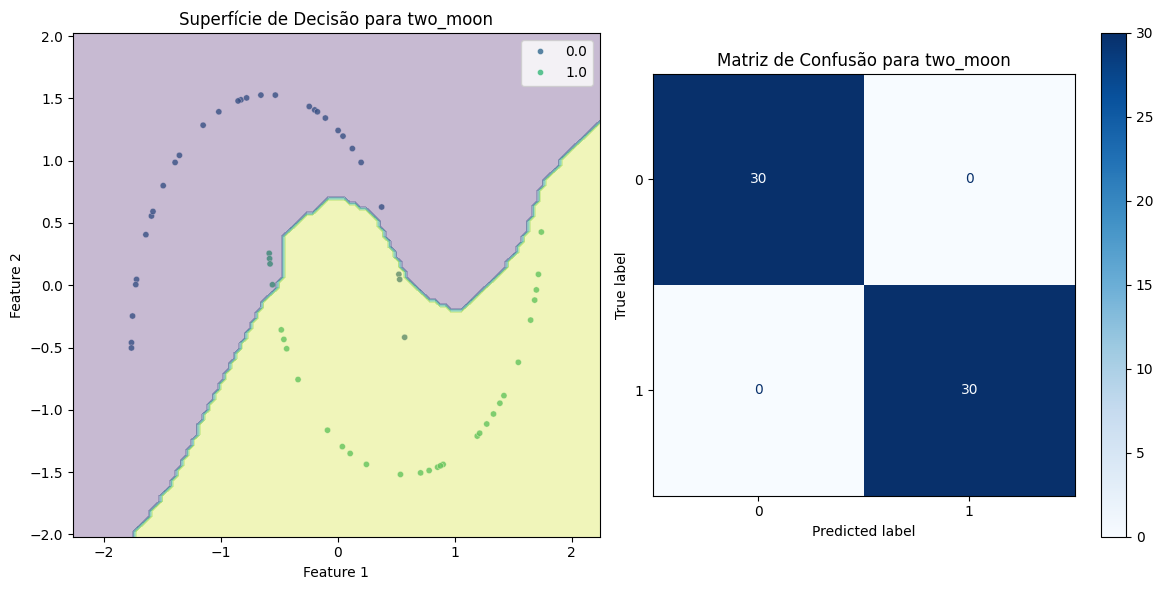


Iniciando treinamento para o Dataset: ripley
(1249, 2) (1249,)
X_train_tensor | X_test_tensor shape: torch.Size([999, 2]) | torch.Size([250, 2])
y_train_tensor | y_test_tensor shape: torch.Size([999, 1]) | torch.Size([250, 1])
y_train_tensor shape: torch.Size([999, 1])
y_test_tensor shape: torch.Size([250, 1])
Modelo MLP: MLP(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): ReLU()
    (8): Linear(in_features=12, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Número de camadas ocultas: 4
Neurônios por camada: 12

Iniciando treinamento...
Epoch [1/300], Train Loss: 0.3475, Train Acc: 91.39%, Test Loss: 0.3740, Test Acc: 87.60%
Epoch [10/300], Train Loss: 0.2339, Train Acc: 90.79%, Test Loss: 0.2689, Test Acc: 86.8

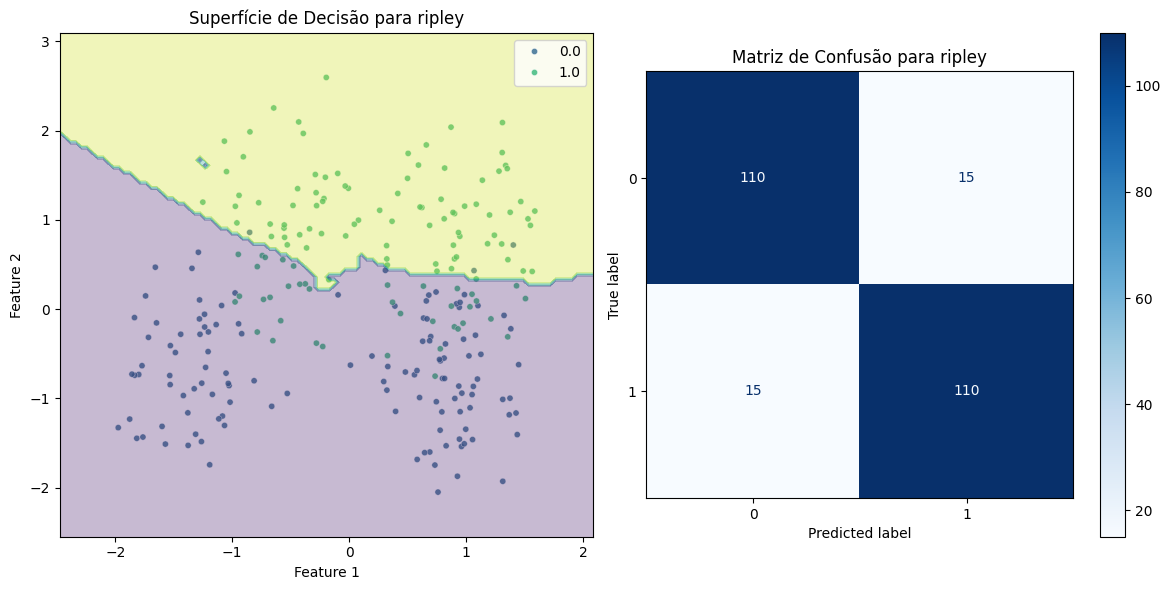


Iniciando treinamento para o Dataset: banana
(5300, 2) (5300,)
X_train_tensor | X_test_tensor shape: torch.Size([4240, 2]) | torch.Size([1060, 2])
y_train_tensor | y_test_tensor shape: torch.Size([4240, 1]) | torch.Size([1060, 1])
y_train_tensor shape: torch.Size([4240, 1])
y_test_tensor shape: torch.Size([1060, 1])
Modelo MLP: MLP(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
Número de camadas ocultas: 5
Neurônios por camada: 10

Iniciando treinamento...
Epoch [1/350], Train Loss: 0.3745, Train Acc: 84.76%, Test Loss: 0.3868, Test Acc: 82.83%
Epoc

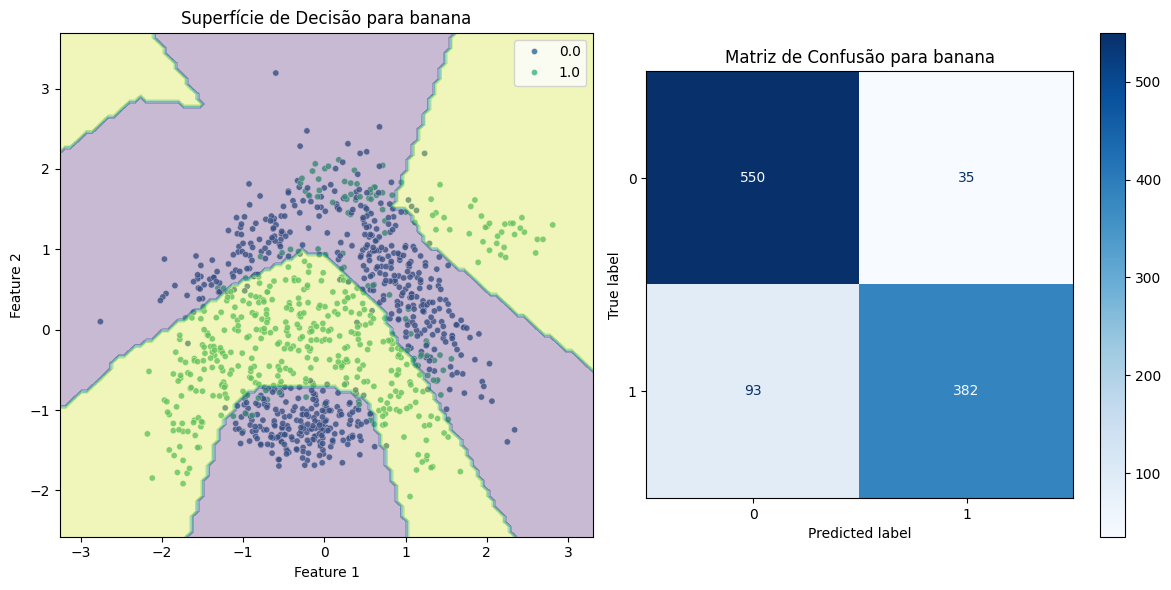

In [ ]:
# --- Execução para todos os datasets ---

# Exemplo de uso para cada dataset
# Dataset Two Moons
dataset_name='two_moon'
run_mlp_experiment(
    dataset_name=dataset_name,
    func_loader=datasets_dict[dataset_name],
    num_hidden_layers=3,
    neurons_per_layer=15, # Ajustar conforme necessário
    num_epochs=200 # Aumentar epochs para melhor convergência
)

# Dataset Ripley
dataset_name='ripley'
run_mlp_experiment(
    dataset_name=dataset_name,
    func_loader=datasets_dict[dataset_name],
    num_hidden_layers=4,
    neurons_per_layer=12,
    num_epochs=300
)

# Dataset Banana
dataset_name='banana'
run_mlp_experiment(
    dataset_name=dataset_name,
    func_loader=datasets_dict[dataset_name],
    num_hidden_layers=5,
    neurons_per_layer=10,
    num_epochs=350
)